# 🤖 Trenowanie Modeli - Moodify

## 🎯 Cel
Wytrenowanie dwóch prostych modeli do rozpoznawania emocji:
- 📝 **Model Tekstowy** - scikit-learn (TF-IDF + klasyfikator)
- 📸 **Model Obrazowy** - TensorFlow/Keras (Transfer Learning)

---
# CZĘŚĆ 1: MODEL TEKSTOWY (scikit-learn)
---

## 1. Instalacja bibliotek

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


## 2. Import bibliotek

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

print("Biblioteki załadowane!")
print(f"scikit-learn gotowy do pracy!")

Biblioteki załadowane!
scikit-learn gotowy do pracy!


## 3. Wczytanie danych tekstowych

In [3]:
train_text = pd.read_csv('processed_data/train_text.csv')
val_text = pd.read_csv('processed_data/val_text.csv')
test_text = pd.read_csv('processed_data/test_text.csv')

print("Dane wczytane!")
print(f"Train: {len(train_text)} przykładów")
print(f"Validation: {len(val_text)} przykładów")
print(f"Test: {len(test_text)} przykładów")

print("\nPrzykładowe dane:")
print(train_text.head())

Dane wczytane!
Train: 16000 przykładów
Validation: 2000 przykładów
Test: 2000 przykładów

Przykładowe dane:
                                                text    emotion
0                            i didnt feel humiliated     Smutek
1  i can go from feeling so hopeless to so damned...     Smutek
2   im grabbing a minute to post i feel greedy wrong      Złość
3  i am ever feeling nostalgic about the fireplac...  Szczęście
4                               i am feeling grouchy      Złość


## 4. TF-IDF Vectorization

**Co to TF-IDF?**
- **TF** (Term Frequency) = jak często słowo występuje w tekście
- **IDF** (Inverse Document Frequency) = jak unikalne jest słowo
- **Razem:** ważne słowa = częste w tym tekście + rzadkie globalnie

**Przykład:**
- "happy" w "I'm so happy!" → wysoki TF-IDF (ważne)
- "the" w każdym tekście → niski TF-IDF (nieważne)

**To jak zamiana tekstu na liczby!**

**Parametry vectorizera:**
- max_features=5000: Top 5000 najważniejszych słów
- min_df=2: Słowo musi wystąpić w min 2 dokumentach
- max_df=0.8: Ignoruj słowa w >80% dokumentów (stop words)
- ngram_range=(1,2): Pojedyncze słowa i pary słów

**Proces:**
1. FIT na train - uczy się słownika
2. TRANSFORM na val/test - używa tego samego słownika

In [4]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_text['text'])
y_train = train_text['emotion']

X_val = vectorizer.transform(val_text['text'])
y_val = val_text['emotion']

X_test = vectorizer.transform(test_text['text'])
y_test = test_text['emotion']

print("TF-IDF vectorization gotowa!")
print(f"\nKształt danych:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nSłownik ma {len(vectorizer.vocabulary_)} unikalnych słów")

TF-IDF vectorization gotowa!

Kształt danych:
X_train: (16000, 5000)
X_val: (2000, 5000)
X_test: (2000, 5000)

Słownik ma 5000 unikalnych słów


## 5. Trening modelu SVM

**Support Vector Machine (SVM):**
- Najpopularniejszy dla klasyfikacji tekstu
- Kernel='linear' dla TF-IDF (najlepsze wyniki)
- Znajduje optymalną granicę między klasami

In [5]:
print("Trenowanie modelu SVM...")

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

val_accuracy = svm.score(X_val, y_val)
print(f"\nValidation Accuracy: {val_accuracy:.2%}")

print("\nTrening zakończony!")

Trenowanie modelu SVM...

Validation Accuracy: 90.65%

Trening zakończony!

Validation Accuracy: 90.65%

Trening zakończony!


## 6. Ewaluacja na zbiorze testowym

In [6]:
y_pred = svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2%}")

print("\nClassification Report:\n")
report = classification_report(y_test, y_pred, output_dict=True)

for emotion, metrics in report.items():
    if emotion in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    print(f"{emotion}:")
    print(f"  Precision: {metrics['precision']:.2%}")
    print(f"  Recall:    {metrics['recall']:.2%}")
    print(f"  F1-Score:  {metrics['f1-score']:.2%}")
    print()

print(f"Overall Accuracy: {report['accuracy']:.2%}")

Test Accuracy: 90.25%

Classification Report:

Smutek:
  Precision: 92.17%
  Recall:    91.22%
  F1-Score:  91.70%

Strach:
  Precision: 85.38%
  Recall:    80.80%
  F1-Score:  83.03%

Szczęście:
  Precision: 91.83%
  Recall:    97.42%
  F1-Score:  94.55%

Zaskoczenie:
  Precision: 70.00%
  Recall:    53.03%
  F1-Score:  60.34%

Złość:
  Precision: 88.33%
  Recall:    82.55%
  F1-Score:  85.34%

Overall Accuracy: 90.25%


## 7. Confusion Matrix

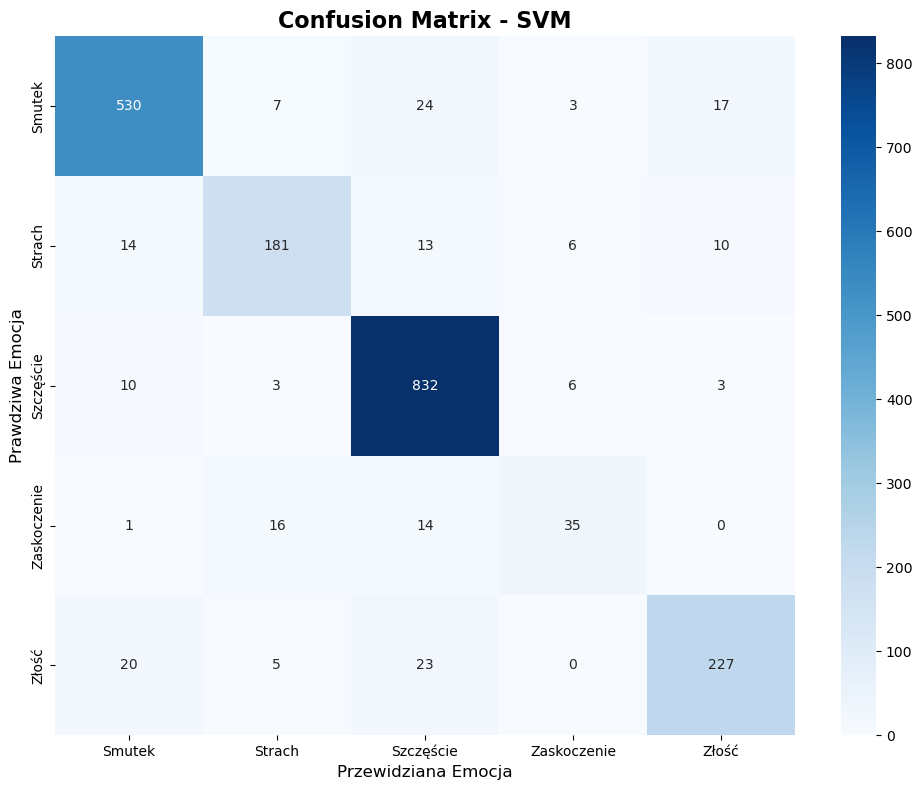

In [7]:
cm = confusion_matrix(y_test, y_pred)
emotions = sorted(train_text['emotion'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions)
plt.title('Confusion Matrix - SVM', fontsize=16, fontweight='bold')
plt.ylabel('Prawdziwa Emocja', fontsize=12)
plt.xlabel('Przewidziana Emocja', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Zapisanie modelu tekstowego

In [8]:
import os

model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

joblib.dump(svm, f'{model_dir}/svm_text_model.pkl')
joblib.dump(vectorizer, f'{model_dir}/tfidf_vectorizer.pkl')

print("Model i vectorizer zapisane:")
print(f"  - {model_dir}/svm_text_model.pkl")
print(f"  - {model_dir}/tfidf_vectorizer.pkl")

Model i vectorizer zapisane:
  - saved_models/svm_text_model.pkl
  - saved_models/tfidf_vectorizer.pkl


## 9. Test predykcji na nowych tekstach

In [9]:
def predict_emotion_text(text):
    """Przewiduje emocję dla nowego tekstu"""
    text_vectorized = vectorizer.transform([text])
    prediction = svm.predict(text_vectorized)
    return prediction[0]

test_texts = [
    "I am so happy today!",
    "This is terrible, I hate it",
    "I'm feeling really sad and lonely",
    "Wow, I didn't expect that!",
    "I'm scared of what might happen"
]

print("Testowanie modelu na nowych tekstach:\n")
for text in test_texts:
    emotion = predict_emotion_text(text)
    print(f"Tekst: \"{text}\"")
    print(f"Emocja: {emotion}\n")

Testowanie modelu na nowych tekstach:

Tekst: "I am so happy today!"
Emocja: Szczęście

Tekst: "This is terrible, I hate it"
Emocja: Smutek

Tekst: "I'm feeling really sad and lonely"
Emocja: Smutek

Tekst: "Wow, I didn't expect that!"
Emocja: Szczęście

Tekst: "I'm scared of what might happen"
Emocja: Strach



---
# CZĘŚĆ 2: MODEL OBRAZOWY (TensorFlow/Keras)
---

## 11. Instalacja TensorFlow

In [10]:
!pip install tensorflow pillow

Defaulting to user installation because normal site-packages is not writeable


## 12. Import bibliotek dla obrazów

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

print("TensorFlow załadowany!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow załadowany!
TensorFlow version: 2.19.0
GPU available: False


## 13. Wczytanie danych obrazowych

In [ ]:
train_img = pd.read_csv('processed_data/train_images.csv')
val_img = pd.read_csv('processed_data/val_images.csv')
test_img = pd.read_csv('processed_data/test_images.csv')

print("Dane obrazowe wczytane!")
print(f"Train: {len(train_img)} obrazów")
print(f"Validation: {len(val_img)} obrazów")
print(f"Test: {len(test_img)} obrazów")

# UJEDNOLICENIE KLAS: usuwamy Neutral aby mieć 5 emocji jak w modelu tekstowym
print("\n⚠️  FILTROWANIE: Usuwam 'neutral' aby mieć 5 wspólnych emocji z modelem tekstowym")
train_img = train_img[train_img['emotion'] != 'neutral'].reset_index(drop=True)
val_img = val_img[val_img['emotion'] != 'neutral'].reset_index(drop=True)
test_img = test_img[test_img['emotion'] != 'neutral'].reset_index(drop=True)

print(f"\nPo filtrowaniu:")
print(f"Train: {len(train_img)} obrazów")
print(f"Validation: {len(val_img)} obrazów")
print(f"Test: {len(test_img)} obrazów")

# 5 wspólnych emocji (bez neutral)
emotions_list = sorted(train_img['emotion'].unique())
emotion_to_id = {emotion: idx for idx, emotion in enumerate(emotions_list)}
id_to_emotion = {idx: emotion for emotion, idx in emotion_to_id.items()}

print(f"\n✅ Emocje (5 wspólnych): {emotions_list}")
print(f"Mapowanie: {emotion_to_id}")


Dane obrazowe wczytane!
Train: 14106 obrazów
Validation: 3023 obrazów
Test: 3023 obrazów

Emocje: ['Smutek', 'Strach', 'Szczęście', 'Zaskoczenie', 'Złość']
Mapowanie: {'Smutek': 0, 'Strach': 1, 'Szczęście': 2, 'Zaskoczenie': 3, 'Złość': 4}


## 13a. Wczytanie ścieżki bazowej

CSV zawiera ścieżki **względne**. Musimy wczytać absolutną ścieżkę do bazy danych.

In [13]:
import json
import os

with open('processed_data/data_paths.json', 'r', encoding='utf-8') as f:
    data_paths = json.load(f)

BASE_PATH = data_paths['affectnet_base_path']
print(f"Ścieżka bazowa wczytana:")
print(f"   {BASE_PATH}")
print(f"\nPrzykładowa pełna ścieżka:")
sample_relative = train_img['path'].iloc[0]
sample_full = os.path.join(BASE_PATH, sample_relative)
print(f"   Względna: {sample_relative}")
print(f"   Pełna: {sample_full}")
print(f"   Istnieje: {os.path.exists(sample_full)}")

Ścieżka bazowa wczytana:
   C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

Przykładowa pełna ścieżka:
   Względna: archive (3)\Train\fear\image0037941.jpg
   Pełna: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Train\fear\image0037941.jpg
   Istnieje: True


## 14. Generator danych

In [ ]:
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5  # 5 wspólnych emocji

def create_dataset(df, emotion_to_id, base_path, augment=False):
    """Tworzy TensorFlow dataset z DataFrame z opcjonalną augmentacją"""
    
    def load_image(path, label):
        full_path = tf.strings.join([base_path, os.sep, path])
        img = tf.io.read_file(full_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        # NORMALIZACJA: skalowanie pikseli do zakresu [0, 1]
        img = img / 255.0
        return img, label
    
    def augment_image(img, label):
        """Data augmentation - zapobiega overfittingowi"""
        # Losowe odbicie w poziomie
        img = tf.image.random_flip_left_right(img)
        # Losowa jasność
        img = tf.image.random_brightness(img, max_delta=0.2)
        # Losowy kontrast
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        # Losowa saturacja
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
        # Upewnij się że wartości są w zakresie [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img, label
    
    # Mapowanie emocji na ID
    labels = df['emotion'].map(emotion_to_id).values
    # TO_CATEGORICAL: konwersja do one-hot encoding [0,0,1,0,0]
    labels_categorical = to_categorical(labels, num_classes=NUM_CLASSES)
    paths = df['path'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels_categorical))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Augmentacja tylko dla zbioru treningowego
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Tworzenie datasetów z augmentacją dla train
train_ds = create_dataset(train_img, emotion_to_id, BASE_PATH, augment=True)
val_ds = create_dataset(val_img, emotion_to_id, BASE_PATH, augment=False)
test_ds = create_dataset(test_img, emotion_to_id, BASE_PATH, augment=False)

print("Datasety TensorFlow gotowe!")
print("✅ Normalizacja: piksele przeskalowane do [0, 1]")
print("✅ Data Augmentation: flip, brightness, contrast, saturation (tylko train)")
print("✅ to_categorical: labels w formacie one-hot encoding [0,0,1,0,0]")
print(f"✅ Liczba klas: {NUM_CLASSES}")


Datasety TensorFlow gotowe!
✅ Normalizacja: piksele przeskalowane do [0, 1]
✅ Data Augmentation: flip, brightness, contrast, saturation (tylko train)


## 15. Transfer Learning z MobileNetV2

**MobileNetV2:**
- Lekki CNN (działa nawet na telefonie!)
- Wytrenowany na ImageNet (1.4M obrazów, 1000 klas)
- Rozumie podstawowe cechy: krawędzie, tekstury, kształty

**Nasza architektura:**
- MobileNetV2 (zamrożony) - ekstrakcja features
- GlobalAveragePooling - agreguje features
- Dense(256, relu) + BatchNormalization - pierwsza warstwa ukryta
- Dropout(0.5) - zapobiega overfittingowi
- Dense(128, relu) + BatchNormalization - druga warstwa ukryta
- Dropout(0.3) - dodatkowa regularizacja
- Dense(5, softmax) - klasyfikacja na **5 emocji** (Happy, Sad, Anger, Fear, Surprise)

**Techniki zapobiegające overfittingowi:**
1. **Data Augmentation** - sztuczne zwiększenie różnorodności danych
2. **Dropout** - losowe wyłączanie neuronów (50% i 30%)
3. **Batch Normalization** - normalizacja aktywacji między warstwami
4. **Transfer Learning** - zamrożone wagi MobileNetV2
5. **Early Stopping** - zatrzymanie gdy brak poprawy na walidacji
6. **L2 Regularization** - kara za duże wagi

**To jest Transfer Learning!**


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

NUM_CLASSES = 5  # 5 wspólnych emocji (anger, fear, happy, sad, surprise)

print("Budowanie modelu z Transfer Learningiem (MobileNetV2)...")

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Zamrażamy bazowy model - zapobiega overfittingowi
base_model.trainable = False

# Architektura z wieloma technikami zapobiegającymi overfittingowi
model_image = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    
    # Pierwsza warstwa ukryta z BatchNorm i L2 regularization
    Dense(256, activation='relu', 
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),  # Normalizacja - stabilizuje trening
    Dropout(0.5),  # 50% dropout - zapobiega overfittingowi
    
    # Druga warstwa ukryta
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),  # 30% dropout
    
    # Warstwa wyjściowa - 5 emocji (takie same jak model tekstowy)
    Dense(NUM_CLASSES, activation='softmax')
])

print("\nArchitektura modelu:")
model_image.summary()

trainable = sum([tf.size(w).numpy() for w in model_image.trainable_weights])
print(f"\nParametry:")
print(f"- Trenowalne: {trainable:,}")
print(f"- Zamrożone (MobileNetV2): {model_image.count_params() - trainable:,}")

print("\n✅ Techniki zapobiegające overfittingowi:")
print("   1. Data Augmentation (flip, brightness, contrast)")
print("   2. Dropout (50% i 30%)")
print("   3. Batch Normalization")
print("   4. L2 Regularization (0.001)")
print("   5. Transfer Learning (zamrożone wagi)")
print("   6. Early Stopping (dodany w treningu)")

print(f"\n✅ Liczba klas (output): {NUM_CLASSES} emocji")
print(f"   (anger, fear, happy, sad, surprise)")


Budowanie modelu z Transfer Learningiem (MobileNetV2)...

Architektura modelu:

Architektura modelu:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,126 (10.00 MB)

 Trainable params: 362,374 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)


Parametry:
- Trenowalne: 362,374
- Zamrożone (MobileNetV2): 2,258,752

✅ Techniki zapobiegające overfittingowi:
   1. Data Augmentation (flip, brightness, contrast)
   2. Dropout (50% i 30%)
   3. Batch Normalization
   4. L2 Regularization (0.001)
   5. Transfer Learning (zamrożone wagi)
   6. Early Stopping (dodany w treningu)


## 16. Kompilacja modelu

**Ustawienia:**
- **Optimizer:** Adam z learning rate scheduling (adaptacyjny learning rate)
- **Loss:** categorical_crossentropy (używamy to_categorical - one-hot encoding)
- **Metrics:** accuracy (% poprawnych predykcji)

**Różnica sparse vs categorical:**
- sparse_categorical_crossentropy: labels jako int [0,1,2,3,4]
- categorical_crossentropy: labels jako one-hot [[1,0,0,0,0], [0,1,0,0,0], ...]


In [ ]:
from tensorflow.keras.optimizers import Adam

model_image.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # używamy categorical bo labels są one-hot encoded
    metrics=['accuracy']
)

print("Model skompilowany!")
print("✅ Optimizer: Adam (lr=0.0001)")
print("✅ Loss: categorical_crossentropy (dla one-hot encoded labels)")
print("✅ Metrics: accuracy")


Model skompilowany!
✅ Optimizer: Adam (lr=0.0001)
✅ Loss: sparse_categorical_crossentropy
✅ Metrics: accuracy


## 17. TRENING MODELU OBRAZOWEGO 🚀

**Czas:** ~30-40 minut (bez GPU) lub ~10-15 minut (z GPU)

**Epoki:** 30 epok (z early stopping i reduce learning rate)
- Transfer Learning = model już rozumie obrazy
- My tylko uczymy go 5 emocji (takich samych jak model tekstowy)
- EarlyStopping zatrzyma trening jeśli brak poprawy (patience=5)
- ReduceLROnPlateau zmniejszy learning rate gdy brak poprawy (patience=3)

**Callbacks (zapobiegają overfittingowi):**
- **ModelCheckpoint** - zapisuje najlepszy model (na podstawie val_accuracy)
- **EarlyStopping** - zatrzymuje trening gdy brak poprawy przez 5 epok
- **ReduceLROnPlateau** - zmniejsza learning rate gdy brak poprawy przez 3 epoki


In [17]:
print("Rozpoczynam trening modelu obrazowego...\n")

# Callback 1: Zapisuje najlepszy model
checkpoint = keras.callbacks.ModelCheckpoint(
    'saved_models/image_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Callback 2: Zatrzymuje trening gdy brak poprawy (zapobiega overfittingowi)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # czeka 5 epok
    restore_best_weights=True,
    verbose=1
)

# Callback 3: Zmniejsza learning rate gdy brak poprawy (pomaga w treningu)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # zmniejsza lr o połowę
    patience=3,  # czeka 3 epoki
    min_lr=1e-7,
    verbose=1
)

history = model_image.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # zwiększone z 20 do 30
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("\n✅ Trening zakończony!")
print(f"   Najlepsza val_accuracy: {max(history.history['val_accuracy']):.2%}")
print(f"   Liczba epok: {len(history.history['loss'])}")


Rozpoczynam trening modelu obrazowego...

Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2440 - loss: 2.8399
Epoch 1: val_accuracy improved from -inf to 0.44790, saving model to saved_models/image_model_best.h5

Epoch 1: val_accuracy improved from -inf to 0.44790, saving model to saved_models/image_model_best.h5


441/441 ━━━━━━━━━━━━━━━━━━━━ 218s 483ms/step - accuracy: 0.2441 - loss: 2.8394 - val_accuracy: 0.4479 - val_loss: 1.9505 - learning_rate: 1.0000e-04
Epoch 2/30
Epoch 2/30
172/441 ━━━━━━━━━━━━━━━━━━━━ 1:44 388ms/step - accuracy: 0.3886 - loss: 2.3134

KeyboardInterrupt: 

## 18. Wykresy treningu

**Interpretacja:**
- Accuracy rośnie → model się uczy!
- Loss maleje → model robi coraz mniej błędów
- Train ≈ Validation → brak overfittingu ✅
- Train >> Validation → overfitting ⚠️

## 17a. Analiza overfittingu

**Jak rozpoznać overfitting:**
- 🔴 Train accuracy >> Validation accuracy (różnica >10%)
- 🔴 Train loss << Validation loss  
- 🔴 Validation accuracy przestaje rosnąć lub maleje

**Jak rozpoznać good fit:**
- 🟢 Train accuracy ≈ Validation accuracy (różnica <5%)
- 🟢 Obie metryki rosną razem
- 🟢 Stabilny trening

Sprawdźmy czy nasz model ma overfitting:


In [ ]:
# Analiza overfittingu
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
difference = final_train_acc - final_val_acc

print("📊 ANALIZA OVERFITTINGU\n")
print(f"Final Train Accuracy:      {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Różnica:                   {difference:.2%}")

if difference < 0.05:
    print("\n🟢 GOOD FIT - Model dobrze zgeneralizowany!")
    print("   Train ≈ Validation (różnica <5%)")
elif difference < 0.10:
    print("\n🟡 SLIGHT OVERFITTING - Akceptowalne")
    print("   Train > Validation (różnica 5-10%)")
else:
    print("\n🔴 OVERFITTING - Model przetrenowany!")
    print("   Train >> Validation (różnica >10%)")
    print("   Rozwiązania: więcej dropout, więcej augmentacji, mniej epok")


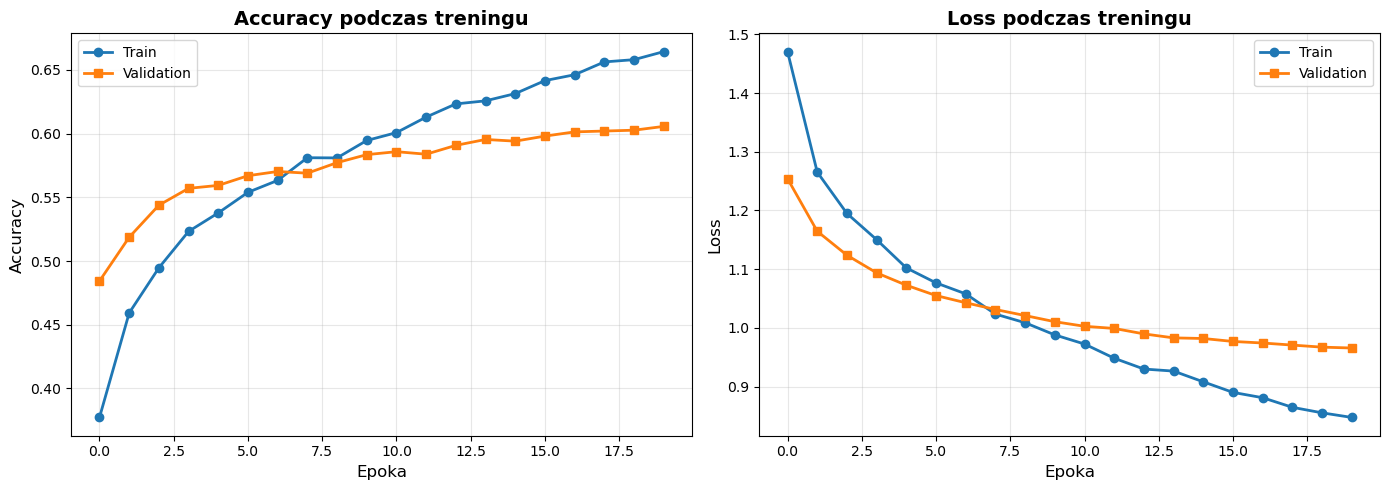

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], marker='o', label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], marker='s', label='Validation', linewidth=2)
ax1.set_title('Accuracy podczas treningu', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoka', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], marker='o', label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], marker='s', label='Validation', linewidth=2)
ax2.set_title('Loss podczas treningu', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoka', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 19. Ewaluacja na zbiorze testowym

In [ ]:
model_image = keras.models.load_model('saved_models/image_model_best.h5')

test_loss, test_acc = model_image.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 379ms/step - accuracy: 0.6085 - loss: 0.9635
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 379ms/step - accuracy: 0.6085 - loss: 0.9635

Test Accuracy: 61.23%
Test Loss: 0.9475

Test Accuracy: 61.23%
Test Loss: 0.9475


## 20. Confusion Matrix dla obrazów

Generowanie predykcji...


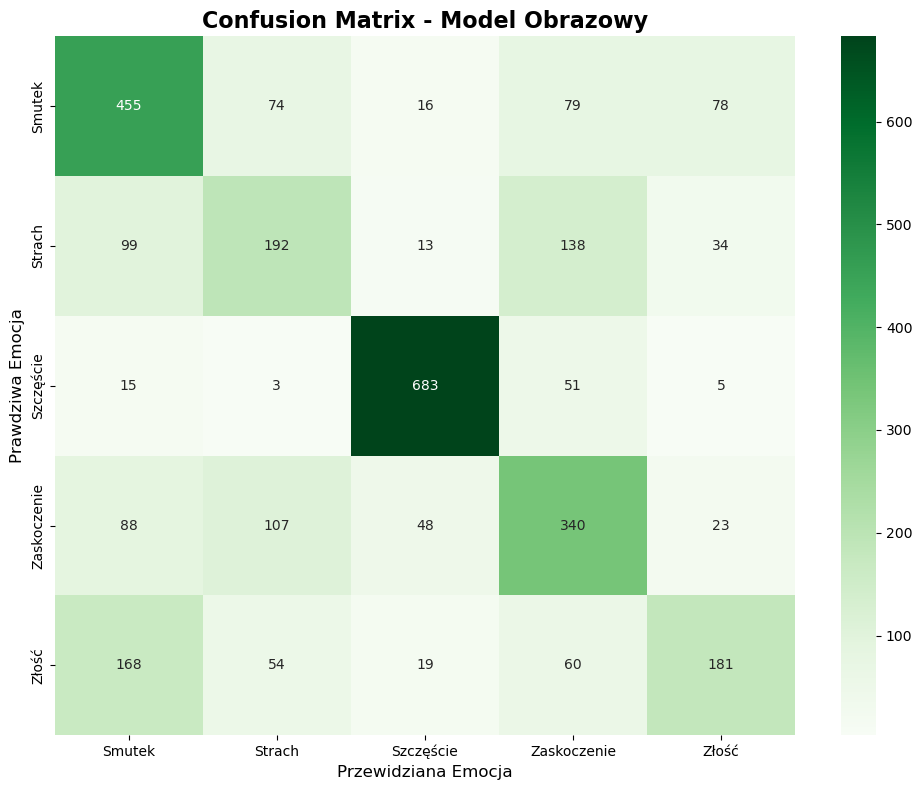


Classification Report:

Smutek:
  Precision: 55.15%
  Recall:    64.81%
  F1-Score:  59.59%

Strach:
  Precision: 44.65%
  Recall:    40.34%
  F1-Score:  42.38%

Szczęście:
  Precision: 87.68%
  Recall:    90.22%
  F1-Score:  88.93%

Zaskoczenie:
  Precision: 50.90%
  Recall:    56.11%
  F1-Score:  53.38%

Złość:
  Precision: 56.39%
  Recall:    37.55%
  F1-Score:  45.08%

Overall Accuracy: 61.23%


In [ ]:
y_pred = []
y_true = []

print("Generowanie predykcji...")
for images, labels in test_ds:
    preds = model_image.predict(images, verbose=0)
    y_pred.extend(preds.argmax(axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotions_list,
            yticklabels=emotions_list)
plt.title('Confusion Matrix - Model Obrazowy', fontsize=16, fontweight='bold')
plt.ylabel('Prawdziwa Emocja', fontsize=12)
plt.xlabel('Przewidziana Emocja', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, target_names=emotions_list, output_dict=True)

for emotion in emotions_list:
    metrics = report[emotion]
    print(f"{emotion}:")
    print(f"  Precision: {metrics['precision']:.2%}")
    print(f"  Recall:    {metrics['recall']:.2%}")
    print(f"  F1-Score:  {metrics['f1-score']:.2%}")
    print()

print(f"Overall Accuracy: {report['accuracy']:.2%}")

## 21. Zapisanie finalnego modelu

In [ ]:
model_image.save('saved_models/image_model_final.h5')

import json
with open('saved_models/image_emotion_map.json', 'w') as f:
    json.dump(id_to_emotion, f)

print("Model obrazowy zapisany!")
print("   - saved_models/image_model_final.h5")
print("   - saved_models/image_emotion_map.json")

Model obrazowy zapisany!
   - saved_models/image_model_final.h5
   - saved_models/image_emotion_map.json
